Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.4 AE

In [9]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42

In [65]:
class SimpleAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim, mid_dim):
    super(SimpleAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.mid_dim = mid_dim    
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(784,)),
            tf.keras.layers.Dense(mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=28*28, activation=tf.nn.sigmoid),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded    

In [61]:
X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.MNIST.value, with_val=True)

In [95]:
autoencoder = SimpleAutoencoder(784, 196, 256)
autoencoder = tf.keras.Sequential([autoencoder.encoder, autoencoder.decoder])

In [96]:
import keras

autoencoder.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy)


In [98]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss=keras.losses.BinaryCrossentropy)

In [99]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/10
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 10.1245 - val_loss: 0.2633
Epoch 2/10
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2638 - val_loss: 0.2631
Epoch 3/10
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2636 - val_loss: 0.2631
Epoch 4/10
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2638 - val_loss: 0.2629
Epoch 5/10
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2643 - val_loss: 0.2630
Epoch 6/10
 151/1608 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2632

KeyboardInterrupt: 

In [226]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrozenEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.predict(X)

In [237]:
class SimpleAutoencoder(tf.keras.Model):
  def __init__(self, inout_dim, latent_dim, mid_dim):
    super(SimpleAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.mid_dim = mid_dim    
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(inout_dim, )),
            tf.keras.layers.Dense(mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=inout_dim, activation=tf.nn.sigmoid),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded    

def create_simple_ae_as_sequence(inout_dim, latent_dim, mid_dim):
  model =  SimpleAutoencoder(inout_dim, latent_dim, mid_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])

def create_simple_ae_from_params(params):
  return SimpleAutoencoder(params["model__inout_dim"], params["model__latent_dim"], params["model__mid_dim"])  

In [114]:
import keras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def evaluate_autoencoder(dataset_name, params, create_plain_ae_fun, create_ae_from_params_fun):

    X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=False)

    keras_reg = KerasRegressor(
        model=create_plain_ae_fun,
        loss="binary_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.001,
        model__inout_dim=784,
        model__latent_dim=128,
        model__mid_dim=256,
        verbose=False,
    )

    grid_search = GridSearchCV(keras_reg, params, refit=False, cv=7, n_jobs=-1)
    grid_search.fit(X_train, X_train)

    print(grid_search.best_score_, grid_search.best_params_)

    X_train_s, X_val_s, _, _, _, _ = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=True)

    ae = create_ae_from_params_fun(grid_search.best_params_)
    ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_["optimizer__learning_rate"]), loss=keras.losses.BinaryCrossentropy)
    ae.fit(X_train_s, X_train_s,
                epochs=grid_search.best_params_["epochs"],
                shuffle=True,
                validation_data=(X_val_s, X_val_s))
    
    return ae
    
    

    

In [115]:
param_grid = {
    'model__inout_dim': [784],
    'model__latent_dim': [10, 64, 128, 192],
    'model__mid_dim': [256, 384, 512],
    'optimizer__learning_rate': [0.001, 0.005, 0.01],
    'epochs': [40]
}

ae = evaluate_autoencoder(utils.Dataset_Select.MNIST.value, param_grid, create_simple_ae_as_sequence, create_simple_ae_from_params)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

0.712966146204136 {'epochs': 40, 'model__inout_dim': 784, 'model__latent_dim': 192, 'model__mid_dim': 384, 'optimizer__learning_rate': 0.001}
Epoch 1/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1542 - val_loss: 0.0820
Epoch 2/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0786 - val_loss: 0.0754
Epoch 3/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0735 - val_loss: 0.0734
Epoch 4/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0714 - val_loss: 0.0722
Epoch 5/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0701 - val_loss: 0.0712
Epoch 6/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0695 - val_loss: 0.0698
Epoch 7/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0686 - val_loss: 0.0711
Epoch 8/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0681 - val_loss: 0.0694
Epoch 9/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0680 - val_loss: 0.0692
Epoch 10/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0

```
0.712966146204136 {'epochs': 40, 'model__inout_dim': 784, 'model__latent_dim': 192, 'model__mid_dim': 384, 'optimizer__learning_rate': 0.001}
```

In [119]:
ae_trained

<SimpleAutoencoder name=simple_autoencoder_88, built=True>

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

frozen_encoder = FrozenEncoder(encoder=ae_trained.encoder)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_encoder', frozen_encoder),
    ('log_reg', LogisticRegression(max_iter=2000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))



1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 489us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.91      0.92      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.95      0.96      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.88      0.90      0.89       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [239]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train_s, X_val_s, _, _, _, _ = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.F_MNIST.value, with_val=True)

simple_ae = SimpleAutoencoder(inout_dim=784, latent_dim=10, mid_dim=384)
simple_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy)
simple_ae.fit(X_train_s, X_train_s,
                epochs=40,
                shuffle=True,
                validation_data=(X_val_s, X_val_s))

frozen_encoder = FrozenEncoder(encoder=simple_ae)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.F_MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_encoder', frozen_encoder),
    ('log_reg', LogisticRegression(max_iter=5000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))



Epoch 1/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3514 - val_loss: 0.2958
Epoch 2/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2938 - val_loss: 0.2903
Epoch 3/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2892 - val_loss: 0.2895
Epoch 4/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2869 - val_loss: 0.2863
Epoch 5/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2859 - val_loss: 0.2857
Epoch 6/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2845 - val_loss: 0.2845
Epoch 7/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2828 - val_loss: 0.2841
Epoch 8/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2836 - val_loss: 0.2839
Epoch 9/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2829 - val_loss: 0.2832
Epoch 10/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2821 - val_loss: 0.2829
Epoch 11/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.2821 - val_loss: 0.2828
Epoch 12/40
1608/1608 ━━━━━━━━

In [131]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rand_frst = Pipeline([
    ('frozen_encoder', frozen_encoder),
    ('rand_frst', RandomForestClassifier(n_estimators=250, random_state=seed))
])

pipeline_rand_frst.fit(X_train, y_train)

y_pred = pipeline_rand_frst.predict(X_test)

print(classification_report(y_test, y_pred))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.92      0.95      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.96      0.92      0.94       892
           6       0.96      0.97      0.97       958
           7       0.96      0.93      0.95      1028
           8       0.93      0.92      0.93       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [240]:
class ConvAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',
                activation='sigmoid'),
            tf.keras.layers.Reshape(target_shape=(784,))
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [270]:
class ConvAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(384, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(latent_dim)
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',
                activation='sigmoid'),
            tf.keras.layers.Reshape(target_shape=(784,))
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
def create_conv_ae_as_sequence(latent_dim):
  model =  ConvAutoencoder(latent_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])

def create_conv_ae_from_params(params):
  return SimpleAutoencoder(params["model__latent_dim"]) 

input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

encoded = layers.Flatten()(x)

x = layers.Reshape((7, 7, 64))(encoded)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [36]:
class ConvAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
            
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
            tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
            tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [6]:
input_img = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

encoded = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Reshape((7, 7, 64))(encoded)
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = tf.keras.models.Model(inputs=input_img, outputs=decoded)

conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [37]:
X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.F_MNIST.value, with_val=False)
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

In [66]:
import keras

conv_ae = ConvAutoencoder(256)

optimizer = tf.keras.optimizers.Adam()
conv_ae.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())

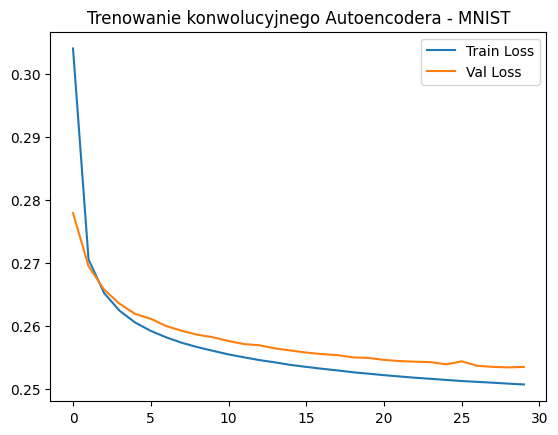

In [67]:
history_conv = conv_ae.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=0,
)

plt.plot(history_conv.history['loss'], label='Train Loss')
plt.plot(history_conv.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Trenowanie konwolucyjnego Autoencodera - MNIST")
plt.show()

In [68]:
encoder = conv_ae.encoder

X_train_conv_encoded = encoder.predict(X_train_reshaped)
X_test_conv_encoded = encoder.predict(X_test_reshaped)

print("Zakodowane cechy (ConvAE) - kształt:", X_train_conv_encoded.shape, X_test_conv_encoded.shape)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Zakodowane cechy (ConvAE) - kształt: (60000, 256) (10000, 256)


In [69]:
from sklearn.linear_model import LogisticRegression

clf_conv_lr = LogisticRegression(solver='newton-cg', max_iter=200)
clf_conv_lr.fit(X_train_conv_encoded, y_train)
y_pred_conv_lr = clf_conv_lr.predict(X_test_conv_encoded)

In [70]:
from sklearn.metrics import classification_report, accuracy_score

print("==== LogisticRegression (ConvAE) ====")
print(classification_report(y_test, y_pred_conv_lr))
acc_conv_lr = accuracy_score(y_test, y_pred_conv_lr)
print(f"Accuracy (ConvAE + LogisticRegression): {acc_conv_lr:.4f}")

==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.83      0.82      1000
           3       0.88      0.91      0.90      1000
           4       0.80      0.81      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.72      0.66      0.69      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy (ConvAE + LogisticRegression): 0.8900


Latent 10:

==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.96      0.94      0.95      1000
           2       0.64      0.60      0.62      1000
           3       0.76      0.84      0.80      1000
           4       0.61      0.68      0.64      1000
           5       0.91      0.89      0.90      1000
           6       0.45      0.34      0.39      1000
           7       0.87      0.89      0.88      1000
           8       0.92      0.94      0.93      1000
           9       0.91      0.92      0.92      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

Accuracy (ConvAE + LogisticRegression): 0.7834

Dense Latent 512:

```
==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.85      0.84      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.83      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.74      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy (ConvAE + LogisticRegression): 0.8979
```


No mod:

```
==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.85      0.85      1000
           3       0.90      0.91      0.91      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.72      0.74      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000
```

In [261]:
conv_ae = ConvAutoencoder(10)

optimizer = tf.keras.optimizers.Adam(1e-3)
conv_ae.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())

X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.F_MNIST.value, with_val=True)

In [262]:
conv_ae.fit(X_train, X_train,
                epochs=40,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 0.3478 - val_loss: 0.2874
Epoch 2/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.2846 - val_loss: 0.2833
Epoch 3/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 0.2796 - val_loss: 0.2790
Epoch 4/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - loss: 0.2781 - val_loss: 0.2778
Epoch 5/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - loss: 0.2762 - val_loss: 0.2768
Epoch 6/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 0.2755 - val_loss: 0.2762
Epoch 7/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 0.2753 - val_loss: 0.2760
Epoch 8/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.2743 - val_loss: 0.2751
Epoch 9/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - loss: 0.2741 - val_loss: 0.2748
Epoch 10/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.2732 - val_loss: 0.2744
Epoch 11/40
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.2734 - val_loss: 0.2743
Epoch 12

In [263]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrozenConvEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.predict(X)


In [266]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

frozen_conv_ae = FrozenConvEncoder(encoder=conv_ae.encoder)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.F_MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_conv_ae', frozen_conv_ae),
    ('log_reg', LogisticRegression(max_iter=5000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1000
           1       0.98      0.96      0.97      1000
           2       0.62      0.60      0.61      1000
           3       0.81      0.85      0.83      1000
           4       0.66      0.68      0.67      1000
           5       0.94      0.92      0.93      1000
           6       0.46      0.39      0.42      1000
           7       0.91      0.94      0.92      1000
           8       0.95      0.95      0.95      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



```
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.92      0.95      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.93      0.91      0.92       892
           6       0.96      0.95      0.95       958
           7       0.95      0.92      0.94      1028
           8       0.93      0.93      0.93       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000
```

In [271]:
import keras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def evaluate_conv_autoencoder(dataset_name, params, create_plain_ae_fun, create_ae_from_params_fun):

    X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=False)

    keras_reg = KerasRegressor(
        model=create_plain_ae_fun,
        loss="binary_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.001,
        model__latent_dim=10,
        verbose=False,
    )

    grid_search = GridSearchCV(keras_reg, params, refit=False, cv=7, n_jobs=-1)
    grid_search.fit(X_train, X_train)

    print(grid_search.best_score_, grid_search.best_params_)

    X_train_s, X_val_s, _, _, _, _ = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=True)

    ae = create_ae_from_params_fun(grid_search.best_params_)
    ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_["optimizer__learning_rate"]), loss=keras.losses.BinaryCrossentropy)
    ae.fit(X_train_s, X_train_s,
                epochs=grid_search.best_params_["epochs"],
                shuffle=True,
                validation_data=(X_val_s, X_val_s))
    
    return ae

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=".*urllib3.*LibreSSL.*")

param_grid = {
    'model__latent_dim': [10, 64, 128, 192],
    'optimizer__learning_rate': [0.0001, 0.005, 0.001],
    'epochs': [40]
}

evaluated_conv_ae = evaluate_conv_autoencoder(utils.Dataset_Select.F_MNIST.value, param_grid, create_conv_ae_as_sequence, create_conv_ae_from_params)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

## VAE

Nieudane próby

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(784)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape(target_shape=(784)),
        ]
    )

In [ ]:
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.prepare_encoder()
        self.decoder = self.prepare_decoder()

    def prepare_encoder(self):
        input_img = tf.keras.layers.Input(shape=(784,))
        x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(input_img)
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.latent_dim + self.latent_dim)(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        return  tf.keras.Model([input_img], [z_mean, z_log_var, z], name="encoder")

    def prepare_decoder(self):
        input = tf.keras.layers.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu)(input)
        x = tf.keras.layers.Reshape(target_shape=(7, 7, 64))(x)
        x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation=tf.nn.sigmoid)(x) 
        x = tf.keras.layers.Reshape(target_shape=(784,))(x)
        return  tf.keras.Model([input], [x], name="decoder")
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        return reconstructed

    def kl_loss(self, z_mean, z_log_var):
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        return tf.reduce_mean(kl_loss)

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.sampling_layer = Sampling()
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(784,)),
                tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
                tf.keras.layers.Reshape(target_shape=(784,))
            ]
        )

    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sampling_layer([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        return reconstructed


    def kl_loss(self, z_mean, z_log_var):
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        return tf.reduce_mean(kl_loss)

In [ ]:
vae = VAE(64)

optimizer = tf.keras.optimizers.Adam(1e-3)
vae.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())

X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.MNIST.value, with_val=True)

In [ ]:
# X_train = X_train.reshape(-1, 784)
# X_val = X_val.reshape(-1, 784)

vae.fit(X_train, X_train,
                epochs=3,
                shuffle=True,
                validation_data=(X_val, X_val))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrozenVEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        z_mean, z_log_var = tf.split(self.encoder.predict(X), num_or_size_splits=2, axis=1)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

frozen_vencoder = FrozenEncoder(encoder=vae.encoder)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_vencoder', frozen_vencoder),
    ('log_reg', LogisticRegression(max_iter=2000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))